In [ ]:
import pandas as pd, torch, torch.nn as nn, numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Make dataset

In [ ]:
device = torch.device("cuda")
full_dataset = pd.read_csv("https://raw.githubusercontent.com/cristobalvch/Spotify-Machine-Learning/master/data/data_moods.csv")
func_dataset = full_dataset[["danceability", "acousticness", "energy", 
                        "instrumentalness", "liveness", "valence",
                        "loudness", "speechiness", "tempo", "key",
                        "time_signature"]]
mood_dataset = pd.DataFrame()
mood_dataset["mood"] = full_dataset["mood"]
le = LabelEncoder() 
mood_dataset["label"] = le.fit_transform(mood_dataset["mood"])
data_output = mood_dataset["label"].values

## Split to train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(func_dataset, 
              data_output, test_size=0.2, random_state=1)

In [ ]:
#X_train.to_csv('normalized_data.csv', index=False)

## Normalization

In [ ]:
X_train_norm = (X_train - X_train.mean() / X_train.std())
X_train_norm = torch.tensor(X_train_norm.values)
y_train = torch.tensor(y_train)

## Tensor dataset

In [ ]:
inputs = X_train_norm.to(device)
labels = y_train.to(device)

train_ds = TensorDataset(inputs, labels)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

## Model

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [ ]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 4
 
model = Model(input_size, hidden_size, output_size)
model.to(device)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train

In [ ]:
num_epochs = 500
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch.float())
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

torch.save(model, 'saved_weights.pt')

## Plot loss and accuracy history

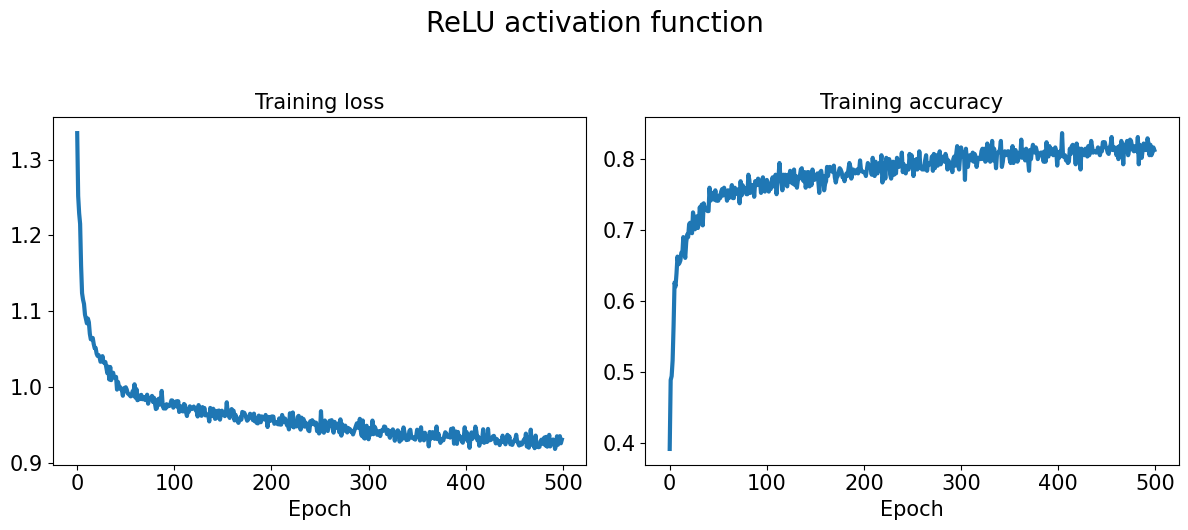

In [ ]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle('ReLU activation function', fontsize=20, y=1.05)
fig.set_facecolor('white')

ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
tensor_list = [tensor.to('cpu') for tensor in accuracy_hist]
accuracy_hist = torch.stack(tensor_list).cpu().numpy()
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
 
plt.show()

## Test


In [ ]:
# Find data for Don't Stop Me Now - Queen
song_to_predict = {'danceability': [0.47],
                   'acousticness': [0.02],
                   'energy': [0.86],
                   'instrumentalness': [0.01],
                   'liveness': [0.6],
                   'valence': [0.6],
                   'loudness':[-5.98], 
                   'speechiness': [0.25], 
                   'tempo': [156.3],
                   'key': [0],
                   'time_signature':[4]}

# Hurt- Johnny Cash
song_to_predict = {'danceability': [0.53],
                   'acousticness': [0.64],
                   'energy': [0.39],
                   'instrumentalness': [0.00022],
                   'liveness': [0.09],
                   'valence': [0.16],
                   'loudness':[-7.63], 
                   'speechiness': [0.02], 
                   'tempo': [90.3],
                   'key': [9],
                   'time_signature':[4]}

df_song_to_predict = pd.DataFrame(song_to_predict)

# Normalize
df_song_to_predict_norm = (df_song_to_predict - X_train.mean() / X_train.std())
df_song_to_predict_norm = torch.tensor(df_song_to_predict_norm.values)

# Predict
inputs = df_song_to_predict_norm.to('cuda')
pred = model(inputs.float())
label_id = torch.argmax(pred)

if label_id == 0:
  output_label = "Calm"
if label_id == 1:
  output_label = "Energetic"
if label_id == 2:
  output_label = "Happy"
if label_id == 3:
  output_label = "Sad"

print('--->', output_label)

---> Sad
